In [10]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Veriyi yeniden yükleyelim
df = pd.read_excel("BIST100.xlsx")

# --- YENİ HEDEF DEĞİŞKENİ ---
# 'Risk_Yarin_Dusecek_mi' adında yeni bir kolon oluşturalım.
# Yarının kapanış fiyatı (shift(-1)), bugünün kapanış fiyatından düşükse 1 (Riskli), değilse 0 (Risksiz) olsun.
df['Risk_Yarin_Dusecek_mi'] = (df['Close'].shift(-1) < df['Close']).astype(int)

# shift(-1) nedeniyle son satırda NaN (boş değer) oluşur, bu satırı temizleyelim.
df = df.dropna()

print("Yeni hedef değişkeni oluşturuldu!")
print(df[['Date', 'Close', 'Risk_Yarin_Dusecek_mi']].tail())

Yeni hedef değişkeni oluşturuldu!
           Date          Close  Risk_Yarin_Dusecek_mi
5142 2020-07-20  119280.898438                      1
5143 2020-07-21  118042.000000                      0
5144 2020-07-22  118079.898438                      0
5145 2020-07-23  119031.203125                      0
5146 2020-07-24  119201.601562                      0


In [11]:
# Özellikler (X) -> Tahmin için kullanacağımız veriler
# Hedef (y) -> Tahmin etmek istediğimiz sonuç (Yarın Düşecek mi?)

# Dikkat: Orijinal 'Risk' kolonunu artık kullanmıyoruz.
X = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] 
y = df["Risk_Yarin_Dusecek_mi"]

In [12]:
# Verinin ilk %80'ini eğitim, son %20'sini test seti olarak ayıralım.
train_size = int(len(df) * 0.80)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print(f"Eğitim verisi boyutu: {len(X_train)}")
print(f"Test verisi boyutu: {len(X_test)}")

Eğitim verisi boyutu: 4117
Test verisi boyutu: 1030


In [13]:
# XGBoost için denenecek parametre setleri
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

# Modeli ve GridSearchCV'yi oluşturalım
# 'f1' skoruna göre en iyi modeli bulmasını söylüyoruz, çünkü verimiz dengesiz.
grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                           param_grid=param_grid, 
                           scoring='f1', 
                           cv=3,  # Çapraz doğrulama kat sayısı
                           verbose=1)

# En iyi parametreleri bulmak için modeli eğitelim
grid_search.fit(X_train, y_train)

# En iyi model ile tahmin yapalım
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# --- SONUÇLARI YORUMLAMA ---
print("\\nEn İyi Parametreler:", grid_search.best_params_)
print("\\n--- KARMAŞIKLIK MATRİSİ ---")
print(confusion_matrix(y_test, y_pred))
print("\\n--- SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:01:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:01:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:01:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:01:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Par

\nEn İyi Parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
\n--- KARMAŞIKLIK MATRİSİ ---
[[ 69 476]
 [ 66 419]]
\n--- SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

           0       0.51      0.13      0.20       545
           1       0.47      0.86      0.61       485

    accuracy                           0.47      1030
   macro avg       0.49      0.50      0.41      1030
weighted avg       0.49      0.47      0.39      1030



C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:01:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [14]:
# --- ADIM 1: GÜÇLÜ YENİ ÖZELLİKLER OLUŞTURALIM ---

# 1. Hareketli Ortalamalar (Momentum Göstergesi)
# Fiyatın genel yönü hakkında fikir verir.
df['MA_5'] = df['Close'].rolling(window=5).mean()  # Kısa vadeli trend
df['MA_20'] = df['Close'].rolling(window=20).mean() # Orta vadeli trend

# 2. Göreceli Güç Endeksi - RSI (Momentum Göstergesi)
# Fiyat hareketlerinin hızını ve değişimini ölçer. Genellikle 14 günlük kullanılır.
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# 3. Hareketli Ortalama Yakınsama/Iraksama - MACD (Momentum Göstergesi)
# İki hareketli ortalama arasındaki ilişkiyi gösterir.
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2

# 4. Gecikme Özellikleri (Lag Features)
# Modelin dünkü ve önceki günkü fiyatları hatırlamasını sağlar.
df['Close_Lag_1'] = df['Close'].shift(1) # Dünkü kapanış
df['Volume_Lag_1'] = df['Volume'].shift(1) # Dünkü işlem hacmi

# 5. Volatilite Oranı (Oynaklık Göstergesi)
# Fiyatlardaki oynaklığı ölçer.
df['Volatility'] = df['Close'].rolling(window=10).std() / df['Close'].rolling(window=10).mean()

# Oluşturduğumuz yeni özellikler nedeniyle oluşacak NaN değerlerini temizleyelim
df = df.dropna()


# --- ADIM 2: YENİ ÖZELLİKLERLE MODELİ TEKRAR EĞİTELİM ---

# Yeni özellik setimizi (X) tanımlayalım
X_new = df[[
    "Open", "High", "Low", "Close", "Volume",
    "MA_5", "MA_20", "RSI", "MACD", "Close_Lag_1", "Volume_Lag_1", "Volatility"
]]

# Hedef (y) aynı kalıyor
y_new = df["Risk_Yarin_Dusecek_mi"]

# Veriyi yeniden kronolojik olarak bölelim
train_size = int(len(df) * 0.80)
X_train_new, X_test_new = X_new[0:train_size], X_new[train_size:len(X_new)]
y_train_new, y_test_new = y_new[0:train_size], y_new[train_size:len(y_new)]

# En iyi modelimizi bu yeni ve güçlü özelliklerle tekrar eğitelim
# (Bir önceki adımdaki `best_model` veya `grid_search.best_estimator_` kullanılabilir)
best_model.fit(X_train_new, y_train_new)
y_pred_new = best_model.predict(X_test_new)


# --- ADIM 3: YENİ SONUÇLARI GÖRELİM! ---
print("--- YENİ ÖZELLİKLERLE SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test_new, y_pred_new))

C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:01:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- YENİ ÖZELLİKLERLE SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

           0       0.43      0.08      0.13       544
           1       0.46      0.88      0.60       482

    accuracy                           0.46      1026
   macro avg       0.44      0.48      0.37      1026
weighted avg       0.44      0.46      0.35      1026



In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Sınıfların sayısını hesaplayalım
# '0' sınıfının sayısı / '1' sınıfının sayısı
scale_pos_weight = y_train_new.value_counts()[0] / y_train_new.value_counts()[1]

# Modeli bu yeni parametre ile tekrar oluşturalım
# En iyi parametreleri kullanmaya devam ediyoruz
dengeli_model = XGBClassifier(
    learning_rate=0.1, 
    max_depth=5, 
    n_estimators=200,
    scale_pos_weight=scale_pos_weight,  # <-- SİHİRLİ DOKUNUŞ!
    use_label_encoder=False, 
    eval_metric='logloss'
)

# Modeli eğitelim
dengeli_model.fit(X_train_new, y_train_new)

# Tahmin yapalım
y_pred_dengeli = dengeli_model.predict(X_test_new)

# Yeni ve daha dengeli sonuçları görelim!
print("--- DENGELENMİŞ MODEL SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test_new, y_pred_dengeli))

C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:01:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- DENGELENMİŞ MODEL SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

           0       0.45      0.12      0.19       544
           1       0.46      0.84      0.59       482

    accuracy                           0.46      1026
   macro avg       0.46      0.48      0.39      1026
weighted avg       0.46      0.46      0.38      1026



C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:01:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


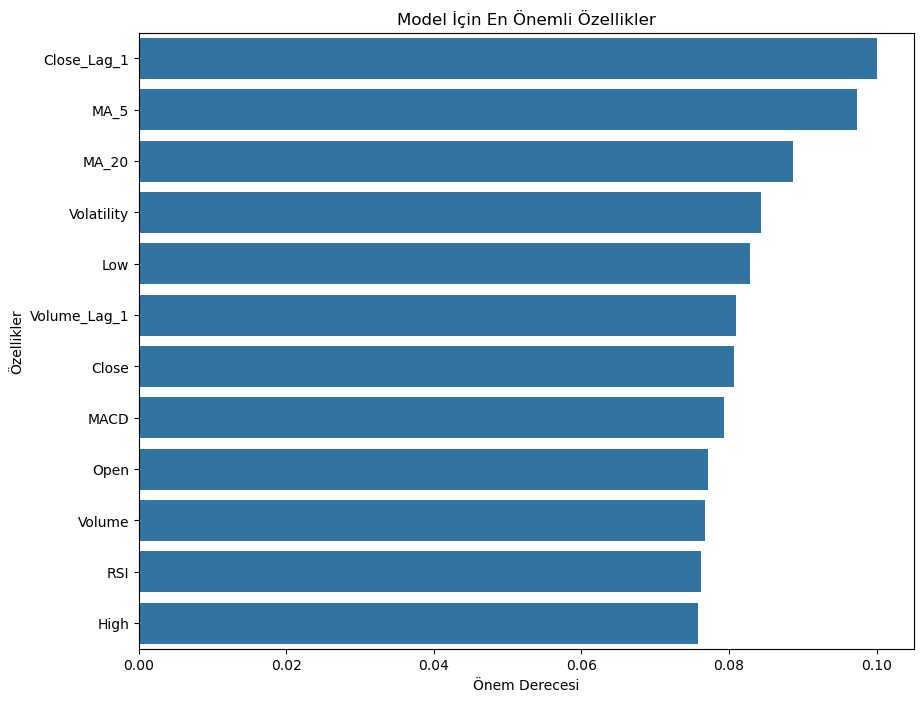

İşte modelimizin en çok dikkate aldığı özellikler:
         feature  importance
9    Close_Lag_1    0.100063
5           MA_5    0.097373
6          MA_20    0.088659
11    Volatility    0.084277
2            Low    0.082807
10  Volume_Lag_1    0.080907
3          Close    0.080708
8           MACD    0.079355
0           Open    0.077109
4         Volume    0.076740
7            RSI    0.076170
1           High    0.075832


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

# Bu kod, bir önceki adımda oluşturduğun
# X_train_new ve y_train_new verilerini kullandığını varsayar.

# En iyi parametrelerle modeli yeniden oluşturalım
# (Not: scale_pos_weight olmadan, çünkü amacımız özelliklerin doğal önemini görmek)
model_feature_importance = XGBClassifier(
    learning_rate=0.1, 
    max_depth=5, 
    n_estimators=200,
    use_label_encoder=False, 
    eval_metric='logloss'
)

# Modeli eğitelim
model_feature_importance.fit(X_train_new, y_train_new)

# Özellik önem skorlarını bir DataFrame'e aktaralım
feature_importances = pd.DataFrame({
    'feature': X_train_new.columns,
    'importance': model_feature_importance.feature_importances_
}).sort_values('importance', ascending=False)

# Görselleştirelim!
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Model İçin En Önemli Özellikler')
plt.xlabel('Önem Derecesi')
plt.ylabel('Özellikler')
plt.show()

print("İşte modelimizin en çok dikkate aldığı özellikler:")
print(feature_importances)

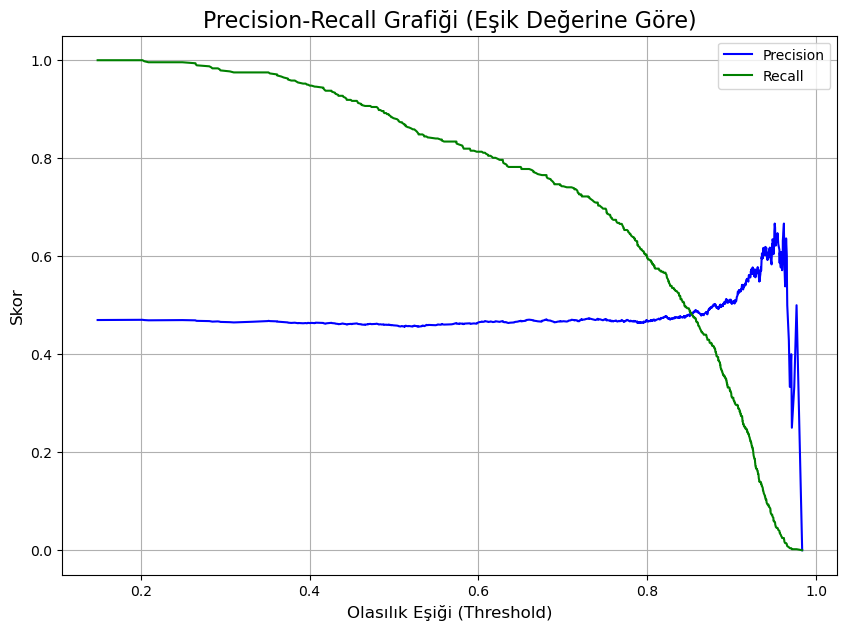

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Bu kod, bir önceki adımda eğittiğin `best_model` ve test verilerini kullandığını varsayar.
# (X_test_new, y_test_new)

# Modelin olasılık tahminlerini alalım
# [:, 1] diyerek sadece '1' sınıfının (Düşüş Olacak) olasılıklarını alıyoruz
y_pred_proba = best_model.predict_proba(X_test_new)[:, 1]

# Farklı eşikler için precision ve recall değerlerini hesaplayalım
precision, recall, thresholds = precision_recall_curve(y_test_new, y_pred_proba)

# Grafiği çizdirelim!
plt.figure(figsize=(10, 7))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="green")
plt.title('Precision-Recall Grafiği (Eşik Değerine Göre)', fontsize=16)
plt.xlabel('Olasılık Eşiği (Threshold)', fontsize=12)
plt.ylabel('Skor', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Bu kod, bir önceki adımda oluşturduğun 
# `best_model` ve test verilerini (X_test_new, y_test_new) kullandığını varsayar.

# Modelin '1' sınıfı (Düşüş Olacak) için olasılık tahminlerini alalım
y_pred_proba = best_model.predict_proba(X_test_new)[:, 1]

# Grafikten bulduğumuz yeni ve akıllı eşik değerimiz!
yeni_esik = 0.82

# Yeni eşiğe göre tahminleri oluşturalım (0 veya 1)
y_pred_yeni_esik = (y_pred_proba >= yeni_esik).astype(int)


# --- FİNAL SONUÇLARI GÖRELİM! ---
print(f"--- YENİ EŞİK DEĞERİ ({yeni_esik}) İLE SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test_new, y_pred_yeni_esik))

print("\n--- YENİ KARMAŞIKLIK MATRİSİ ---")
print(confusion_matrix(y_test_new, y_pred_yeni_esik))

--- YENİ EŞİK DEĞERİ (0.82) İLE SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

           0       0.54      0.45      0.49       544
           1       0.48      0.57      0.52       482

    accuracy                           0.50      1026
   macro avg       0.51      0.51      0.50      1026
weighted avg       0.51      0.50      0.50      1026


--- YENİ KARMAŞIKLIK MATRİSİ ---
[[244 300]
 [209 273]]
